In [14]:
%matplotlib inline

import os
import json
import csv

import pandas as pd
import numpy as np

import sklearn.feature_extraction.text as sk_text
from collections.abc import Sequence

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import optimizers

In [15]:
# Read the TSV file into a Pandas DataFrame
merged_df = pd.read_csv('df_merged.tsv', delimiter='\t', encoding='utf-8')

# Display the DataFrame
merged_df

,all_reviews,name,city,food_culture
0,Ate here for the 1st time on Saturday 08/07/20...,Frankie's Raw Bar,New Port Richey,American
1,"Took me for 40 bucks through grubhub, no call ...",The Original Italian Pie,Gentilly,Italian
2,This place is sadly perm closed. I was hoping ...,Chris's Sandwich Shop,Ardmore,American
3,Love their asiago roll. That and a cup of coff...,Manhattan Bagel,Willow Grove,NaN
4,"Had lunch last week, second time I was disappo...",Cracker Barrel Old Country Store,Mount Holly,American
...,...,...,...,...
33936,I had the smoked salmon ramen special. The bro...,Nom Nom Japanese Kitchen,Paoli,Japanese
33937,Last night was my first time over at F&M on Tc...,F & M Patio Bar,New Orleans,American
33938,I recently stopped here for lunch.I had debs c...,Ruby's Kitchen,Nashville,American
33939,Went in for lunch and tried the jerk chicken a...,Taste of the Islands,Norristown,Caribbean


In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Input

## building and training the neural network, and Gensim for working with Word2Vec embeddings

### find out optimal max_words

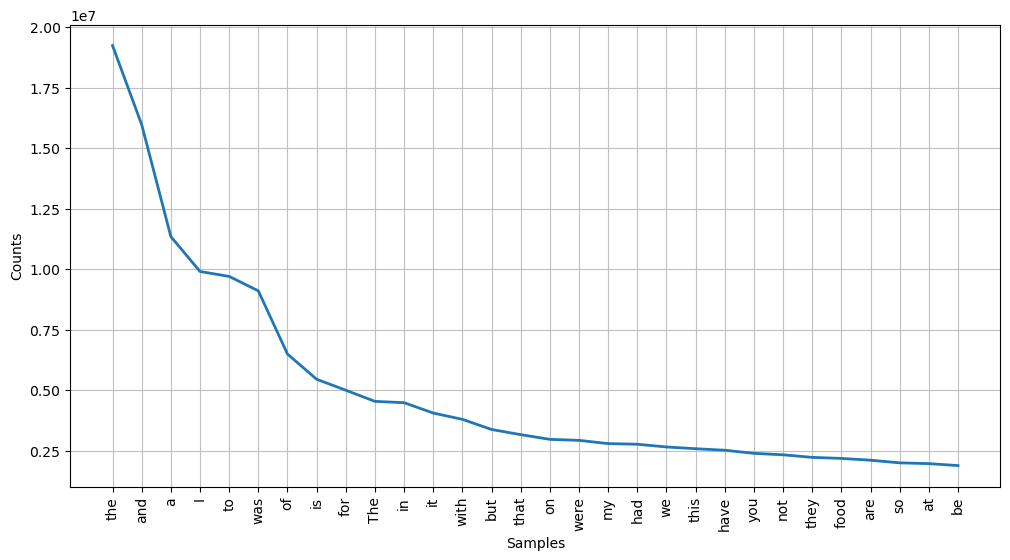

In [4]:
texts = merged_df['all_reviews'].tolist()
# defining the max_words
from nltk import FreqDist
import matplotlib.pyplot as plt

flat_texts = [word for text in texts for word in text.split()]
word_freq = FreqDist(flat_texts)

# Plot the word frequency distribution
plt.figure(figsize=(12, 6))
word_freq.plot(30, cumulative=False)
plt.show()


In [17]:
# Tokenization
max_words = 10000  # the maximum number of words to keep based on word frequency
tokenizer = Tokenizer(num_words=max_words)
# fits the tokenizer on the text data
tokenizer.fit_on_texts(texts)
#  converts the text into sequences of integers
sequences = tokenizer.texts_to_sequences(texts)

In [18]:
# Padding sequences to a fixed length
max_sequence_length = 100  
# for creating consistent input shapes for the neural network
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [19]:
# Word2Vec Embeddings --> captures semantic relationships between words in the given context
import random
subsample_size = 1000  # Adjust this based on the available memory
subsampled_texts = random.sample(texts, subsample_size)

word2vec_model = Word2Vec(sentences=[text.split() for text in subsampled_texts], vector_size=50, window=5, min_count=1, workers=4)

In [20]:
# Create an embedding matrix
embedding_matrix = word2vec_model.wv.vectors

### CNN model creation
text classification

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization

# Model Architecture - Improved CNN
embedding_dim = 50 
max_words = 10000  # the maximum number of words to keep based on word frequency
max_sequence_length = 100  # for creating consistent input shapes for the neural network
num_filters = 64
filter_size = 3
dropout_rate = 0.5  

model = Sequential()

# Embedding layer using pre-trained Word2Vec embeddings
model.add(Embedding(input_dim=344177, output_dim=embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))

# Convolutional layers with dropout
model.add(Conv1D(num_filters, filter_size, activation='relu'))
model.add(Dropout(dropout_rate))

# Global max pooling layer
model.add(GlobalMaxPooling1D())

# Batch normalization layer
model.add(BatchNormalization())

# Fully connected layers with dropout
model.add(Dense(32, activation='relu'))
model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(max_words, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 50)           17208850  
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            9664      
                                                                 
 dropout (Dropout)           (None, 98, 64)            0         
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)              

In [23]:
# Save the model
model.save('unsupervised_model.h5')

C:\Users\rimsa\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# Extract features from the hidden layers
encoder = Model(inputs=model.input, outputs=model.layers[3].output)
encoded_features = encoder.predict(padded_sequences)

1061/1061 [==============================] - 2s 1ms/step


In [25]:
encoded_features

array([[ 7.635695 ,  5.9011364,  8.266461 , ...,  5.167633 ,  5.773407 ,
         5.5821066],
       [ 6.470402 ,  5.4614196,  7.5837216, ...,  7.1966352,  6.7472515,
         6.1772313],
       [ 6.470402 ,  6.3621664,  6.4775076, ...,  5.3611164,  5.4898906,
         5.3609147],
       ...,
       [ 5.719757 ,  4.6966333, 10.651087 , ...,  6.697357 ,  5.121059 ,
         7.374079 ],
       [ 5.2293243,  6.3037343,  7.764915 , ...,  6.2998786,  5.7839923,
         5.711975 ],
       [ 6.0136714,  6.337831 ,  9.089235 , ...,  6.843374 ,  6.1541324,
         5.6014037]], dtype=float32)